The Generic Tone Mapping function could approximate most of known TM functions.
And I want parameter sets to approximate various TM functions. 
(asinh, log, filmic, for example)

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [118]:
tmg = Mantiuk_Seidel(*[1.38, 0.71, 1.99, 2.10])

In [ ]:
tmg.apply()

In [25]:
def tm_generic(x, 
               a=0.125,
               d=0.975,
               mid_in=0.25,
               mid_out=0.18):
    """
    there's a set of rule among the parameters. 
    e.g., following the naming convention of Mantiuk*Seidel 08,
    1) b - dl < b 
    2) b < b + dh
    3) ... 
    
    """
    hdr_max = x.max()
    ad = a * d
    midi_pow_a  = pow(mid_in, a)
    midi_pow_ad = pow(mid_in, ad)
    hdrm_pow_a  = pow(hdr_max, a)
    hdrm_pow_ad = pow(hdr_max, ad)
    u = hdrm_pow_ad * mid_out - midi_pow_ad * mid_out
    v = midi_pow_ad * mid_out

    b = -((-midi_pow_a + (mid_out * (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v)) / u) / v)
    c = (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v) / u

    x[x>hdr_max] = hdr_max
    z = np.power(x, a)
    return z / (np.power(z, d) * b + c)

## Find Genertic parameters of corresponding knwon functions

In [26]:
from astrobf import tmo

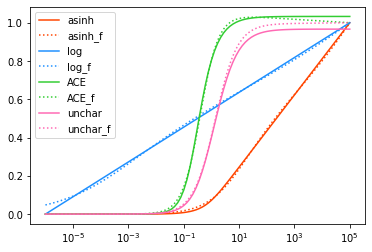

[  7.23241223e-01   8.71323557e-01   6.84716700e+04   9.64734824e-01]
[  3.56857091e-01   8.73780287e-01   4.92558695e+04   9.68102536e-01]
[ 1.32724315  1.00292268  4.16492408  0.99538989]
[  1.09533468e+00   9.99377882e-01   3.14910557e+03   9.97440276e-01]


In [67]:
from scipy import optimize

p_ = {'a':0.125, 'd':0.975, 'mid_in':0.25, 'mid_out':0.18} # == Uncharted

xx = 10**np.linspace(-6,5,100)


tmo_log = lambda xx : (np.log10(xx) - np.log10(xx).min())/np.log10(xx).ptp()
tmo_asinh = lambda xx : np.arcsinh(xx)/max(np.arcsinh(xx))

p_asinh, _ = optimize.curve_fit(tm_generic, xx, tmo_asinh(xx))
p_log, _ = optimize.curve_fit(tm_generic, xx, tmo_log(xx))
p_ACEf,_ = optimize.curve_fit(tm_generic, xx, tmo.ACESFilm(xx))
p_unchar, _ = optimize.curve_fit(tm_generic, xx, tmo.normalized_uncharted(xx, xx.max()))

params = [p_asinh, p_log, p_ACEf, p_unchar]

fig,ax = plt.subplots()

#ax.plot(xx, yy, label='generic')
ax.plot(xx, tmo_asinh(xx), label='asinh', c='orangered')
ax.plot(xx, tm_generic(xx, *p_asinh), label='asinh_f', c='orangered', ls=':')
ax.plot(xx, tmo_log(xx), label='log', c='dodgerblue')
ax.plot(xx, tm_generic(xx, *p_log), label='log_f', c='dodgerblue', ls=":")
ax.plot(xx, tmo.ACESFilm(xx), label='ACE', c='limegreen')
ax.plot(xx, tm_generic(xx, *p_ACEf), label='ACE_f', c='limegreen', ls=":")
ax.plot(xx, tmo.uncharted(xx), label='unchar', c='hotpink')
ax.plot(xx, tm_generic(xx, *p_unchar), label='unchar_f', c='hotpink', ls=":")

ax.set_xscale('log')
plt.legend()

plt.savefig("TMO_param_fittings.png", facecolor="white", dpi=200)
plt.show()


for pp in params:
    print(pp)

In [68]:
p_unchar

array([  1.09533468e+00,   9.99377882e-01,   3.14910557e+03,
         9.97440276e-01])

# Fitted params result in unstable images... Don't use them

In [50]:
plt.close("all")

In [123]:
class Mantiuk_Seidel():
    def __init__(self, *kwargs):
        """
        "Generic" tone curve. eq.3 in Mantiuk & Seidel 2008

        b : brightness adjustment param
        c : contrast parameter
        dl : lower midtone range
        dh : higher midtone range
        gamma : display gamma
        """
        self.gamma = 2.2
        self.update(*kwargs)

    def update(self, b, c, dl, dh):
        self.b = b
        self.c = c
        self.dl = dl
        self.dh = dh
        self.al = (c*dl-1)/dl # contrast compression for shadows
        self.ah = (c*dh-1)/dh # contrast compression for highlights

    def apply(self, lum):
        lp = np.log10(lum) # L prime
        #cp = gamma*c/np.log(10) 

        conditions=[lp <= self.b-self.dl,
                    (self.b-self.dl < lp) * (lp <= self.b),
                    (self.b < lp) * (lp <= self.b+self.dh),
                    lp > self.b+self.dh]
        
        functions=[0,
                   lambda lp : 1/2*self.c*(lp-self.b)/(1-self.al*(lp-self.b))+1/2,
                   lambda lp : 1/2*self.c*(lp-self.b)/(1+self.ah*(lp-self.b))+1/2,
                   1]
        
        return np.piecewise(lp, conditions, functions)

In [127]:
params = [[1.68, 0.53, 4.12, 2.46],
          [1.38, 0.71, 1.99, 2.10],
          [1.90, 0.88, 2.43, 1.48],
          [1.30, 0.69, 2.53, 7.60]]

tmo_names = ['BriAda', 'log', 'Ashik', 'Retinex']

[1.68, 0.53, 4.12, 2.46]
[1.38, 0.71, 1.99, 2.1]
[1.9, 0.88, 2.43, 1.48]
[1.3, 0.69, 2.53, 7.6]


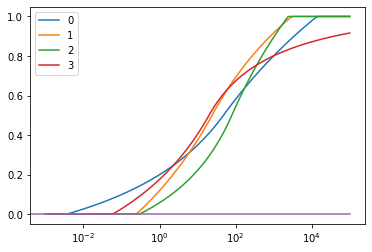

In [132]:
xx = 10**np.linspace(-3,5,100)
fig,ax = plt.subplots()
for i, pp in enumerate(params):
    print(pp)
    tmg = Mantiuk_Seidel(*pp)
    #ax.plot(xx, tm_generic(xx, *pp), label=f'{i}')
    ax.plot(xx, tmg.apply(xx), label=f'{i}')
ax.plot([0,1e5], [0,0])
ax.set_xscale('log')
plt.legend()
plt.show()

In [158]:
def Mantiuk_Seidel(lum, b, c, dl, dh):
        al = (c*dl-1)/dl # contrast compression for shadows
        ah = (c*dh-1)/dh
        lp = np.log10(lum) # L prime
        
        conditions=[lp <= b-dl,
                    (b-dl < lp) * (lp <= b),
                    (b < lp) * (lp <= b+dh),
                    lp > b+dh]
        
        functions=[0,
                   lambda lp : 1/2*c*(lp-b)/(1-al*(lp-b))+1/2,
                   lambda lp : 1/2*c*(lp-b)/(1+ah*(lp-b))+1/2,
                   1]
        
        return np.piecewise(lp, conditions, functions)

/home/hoseung/anaconda3/envs/tm38/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


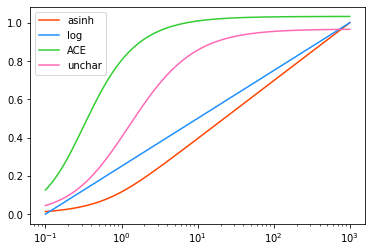

[ 1.36799498  0.66129614  2.00660697  1.65747831]
[ 1.   0.5  2.   2. ]
[-0.66766768  0.73343043 -2.93101507  1.33132414]
[ 0.13426317  1.58487725  1.29653073  1.60193001]


In [153]:
xx = 10**np.linspace(-1,3,1000)

tmo_log = lambda xx : (np.log10(xx) - np.log10(xx).min())/np.log10(xx).ptp()
tmo_asinh = lambda xx : np.arcsinh(xx)/max(np.arcsinh(xx))

p_asinh, _ = optimize.curve_fit(Mantiuk_Seidel, xx, tmo_asinh(xx))
p_log, _ = optimize.curve_fit(Mantiuk_Seidel, xx, tmo_log(xx))
p_ACEf,_ = optimize.curve_fit(Mantiuk_Seidel, xx, tmo.ACESFilm(xx))
p_unchar, _ = optimize.curve_fit(Mantiuk_Seidel, xx, tmo.normalized_uncharted(xx, xx.max()))

params = [p_asinh, p_log, p_ACEf, p_unchar]

fig,ax = plt.subplots()

#ax.plot(xx, yy, label='generic')
ax.plot(xx, tmo_asinh(xx), label='asinh', c='orangered')
#ax.plot(xx, tm_generic(xx, *p_asinh), label='asinh_f', c='orangered', ls=':')
ax.plot(xx, tmo_log(xx), label='log', c='dodgerblue')
#ax.plot(xx, tm_generic(xx, *p_log), label='log_f', c='dodgerblue', ls=":")
ax.plot(xx, tmo.ACESFilm(xx), label='ACE', c='limegreen')
#ax.plot(xx, tm_generic(xx, *p_ACEf), label='ACE_f', c='limegreen', ls=":")
ax.plot(xx, tmo.uncharted(xx), label='unchar', c='hotpink')
#ax.plot(xx, tm_generic(xx, *p_unchar), label='unchar_f', c='hotpink', ls=":")

ax.set_xscale('log')
plt.legend()

#plt.savefig("TMO_param_fittings.png", facecolor="white", dpi=200)
plt.show()

for pp in params:
    print(pp)

In [154]:
plt.close("all")

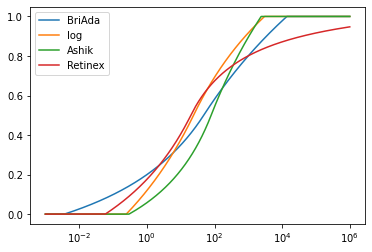

In [164]:
params = [[1.68, 0.53, 4.12, 2.46],
          [1.38, 0.71, 1.99, 2.10],
          [1.90, 0.88, 2.43, 1.48],
          [1.30, 0.69, 2.53, 7.60]]

tmo_names = ['BriAda', 'log', 'Ashik', 'Retinex']

xx = 10**np.linspace(-3,6,1000)

fig, ax = plt.subplots()
for pp, name in zip(params, tmo_names):
    ax.plot(xx, Mantiuk_Seidel(xx, *pp), label=name)
ax.set_xscale('log')
plt.legend()
plt.show()